In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numba as nb
import plotly.graph_objects as go 

In [2]:
@nb.njit
def update_low( N, s, nn, beta, J, h ):
    
    # size 1 flip
    for _ in range(N*N*N):

        xyz = np.random.randint(0,N*N*N)
        
        nn_i = nn[xyz]
        sum_s_j = s[nn_i[0]] + s[nn_i[1]] + s[nn_i[2]] + s[nn_i[3]] + s[nn_i[4]] + s[nn_i[5]] 
        
        new_s = np.random.uniform(0.0,1.0,3) - 0.5
        new_s /= np.sqrt( new_s @ new_s.T )
        
        delta_H = ( s[xyz] - new_s) @ ( sum_s_j * J + h ).T

        delta_S = np.exp( - beta * delta_H )

        if delta_H < 0.0 or np.random.uniform(0.0,1.0) < delta_S:
            s[xyz] = new_s
    

class Ising:
    
    def __init__(self, N, J, h):
        self.N = N
        self.J = J
        self.h = h
        
        self.s = np.zeros((N*N*N,3), int)
        self.nn = np.zeros((N*N*N,6), int)
        
        for x in range(N):
            for y in range(N):
                for z in range(N):
                    xp = (x + 1) % N
                    xm = (x - 1) % N 
                    yp = (y + 1) % N 
                    ym = (y - 1) % N
                    zp = (z + 1) % N
                    zm = (z - 1) % N
                    
                    xyz = x*N*N+y*N+z
                    self.nn[xyz,0] = xp*N*N+y*N+z
                    self.nn[xyz,1] = xm*N*N+y*N+z
                    self.nn[xyz,2] = x*N*N+yp*N+z
                    self.nn[xyz,3] = x*N*N+ym*N+z
                    self.nn[xyz,4] = x*N*N+y*N+zp
                    self.nn[xyz,5] = x*N*N+y*N+zm
    
    def show(self):
            pass
        
    def M(self):
        return np.mean( self.s , axis=0 )

    def H( self ):

        N = self.N
        nn = self.nn
        s = self.s
        H = np.zeros(N*N*N)

        for xyz in range(N*N*N):
            
            nn_i = nn[xyz]
            sum_s_j = s[nn_i[0]] + s[nn_i[1]] + s[nn_i[2]] + s[nn_i[3]] + s[nn_i[4]] + s[nn_i[5]] 
        
            H[xyz] = - s[xyz] @ ( sum_s_j * self.J + self.h ).T

        return H.reshape(N,N,N)

    def Mr( self ):

        N = self.N
        nn = self.nn
        s = self.s
        Mr = np.zeros_like(s).astype(float)

        for xy in range(N*N):

            nn_i = nn[xyz]
            sum_s_j = s[nn_i[0]] + s[nn_i[1]] + s[nn_i[2]] + s[nn_i[3]] + s[nn_i[4]] + s[nn_i[5]] 
    
            Mr[xy] = s[xy] / 2.0 + sum_s_j / 8.0 

        return Mr.reshape(N,N)

    def cold_start(self):
        N = self.N
        
        s0 = np.random.uniform(0.0,1.0,3) - 0.5
        s0 /= np.sqrt( s0 @ s0.T )
        
        self.s = s0 + np.zeros((N*N*N,3))
        
    def hot_start(self):
        N = self.N
        self.s = np.zeros((N*N*N,3))
        for i in range(N*N*N):
            s0 = np.random.uniform(0.0,1.0,3) - 0.5
            s0 /= np.sqrt( s0 @ s0.T )
            self.s[i] = s0 

    def update( self, beta ):
        N = self.N
        nn = self.nn
        s = self.s
        
        update_low( N, s, nn, beta, self.J, self.h )
                
    def thermalize( self, beta, steps ):
#        s0 = self.s.copy()
        
        for step in range(steps):
            self.update( beta )
#            a = self.angle(s0)
#            if a > np.pi / 2 * 
#        print( beta, self.angle(s0) )
    
    def angle( self, other_s ):
        ab = np.dot( self.s, other_s )
        aa = np.dot( self.s, self.s )
        bb = np.dot( other_s, other_s )
        
        cos_ab = ab / np.sqrt(aa*bb)
        if cos_ab >= 1:
            return 0.0
        if cos_ab <= -1:
            return np.pi
        
        return np.arccos( cos_ab )


In [3]:
m = []
b = []
h = []

I = Ising( 8, -1.0, np.array([0.0, 1.0, 0.0]))

for _ in range(10):
    
    I.hot_start()
    I.thermalize( 0.01, 100 )

    for beta in np.linspace( 0.01, 1.2, 32 ):

        I.thermalize( beta, 1000 )

        b.append(beta)
        m.append(I.M())
        h.append(np.mean(I.H()))
        
    for beta in np.linspace( 1.2, 0.01, 32 ):
        I.thermalize( beta, 1000 )
        b.append(beta)
        m.append(I.M())
        h.append(np.mean(I.H()))
        
    print('-', end='')

----------

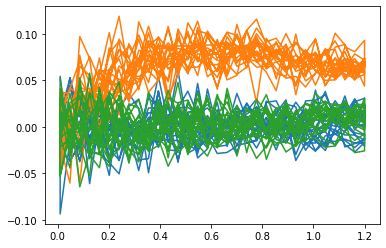

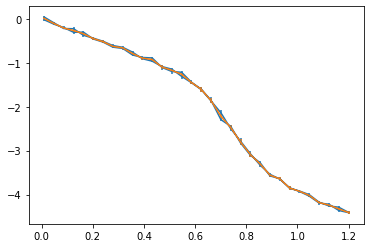

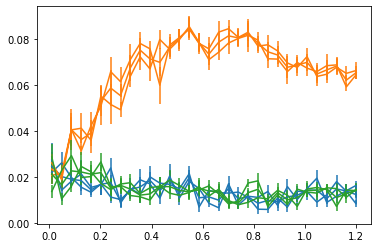

In [4]:
plt.plot(b,m)
plt.show()


b_ = np.array(b).reshape((10,64))
m_ = np.array(m).reshape((10,64,3))
h_ = np.array(h).reshape((10,64))

beta = np.mean(b_, axis=0)
avem = np.mean( np.abs(m_), axis=0).T
stdm = np.std(np.abs(m_), axis=0).T / np.sqrt(m_.shape[0])

aveh = np.mean( h_, axis=0)
stdh = np.std(h_, axis=0) / np.sqrt(h_.shape[0])

def r(x):
    n = x.size
    n2 = n//2
    return ( x[0:n2:1] + x[n:n2-1:-1] ) / 2.0

plt.errorbar( beta, aveh, stdh )
plt.errorbar( r(beta), r(aveh), r(stdh) )
plt.show()

for d in [0,1,2]:
    p = plt.errorbar( beta, avem[d], stdm[d] )
    plt.errorbar( r(beta), r(avem[d]), r(stdm[d]) , color = p[0].get_color())
plt.show()

In [8]:
beta_interesting = 0.6

I.hot_start()

for beta in np.linspace( 0.01, beta_interesting, 32 ):
    I.thermalize( beta, 100 )

I.thermalize( beta_interesting, 1000 )



x = np.linspace(0, I.N, I.N) + 0.5
y = np.linspace(0, I.N, I.N) + 0.5
z = np.linspace(0, I.N, I.N) + 0.5
xv, yv, zv = np.meshgrid(x, y, z)
fig = go.Figure(data = go.Cone(
    x = xv.flatten(),
    y = yv.flatten(),
    z = zv.flatten(),
    u = I.s[:,0],
    v = I.s[:,1],
    w = 1.1 * I.s[:,2],
    sizemode="absolute",
    showscale=False,
    sizeref=0))

fig.update_layout(scene=dict(aspectratio=dict(x=1, y=1, z=0.8),
                             camera_eye=dict(x=1.2, y=1.2, z=0.6)))
fig.update_layout(width=1000, height=1000)
fig.show()

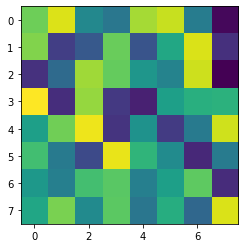

In [9]:
plt.imshow( I.s.reshape(I.N,I.N,I.N,3)[:,0,:,1] )

In [7]:
u

NameError: name 'u' is not defined